# Factorized Observables to Regress Conditional Expectation (FORCE)
## Hunting for New Physics with Factorization
Ray Wynne and Eric M. Metodiev, MIT

In this notebook, we implement a model-independent new physics search strategy, applied to the LHC Olympics 2020 [Development Dataset](https://zenodo.org/record/2629073#.XqLu_shKiUk). The dataset contains 1 million QCD events and up to 100k new physics events, $W' \to XY$ with $m_{W'}=3.5$ TeV, $m_X = 500$ GeV, and $m_Y = 100$ GeV. Events are required to have at least one $R=1.0$ anti-$k_T$ jet with $p_T>1.2$ TeV. 

The key idea is to break your event into factorized objects (here, jets), and predict their kinematics $p_T$ from their scale and boost-invariant substructure $O$. In the broad case of factorized new physics, the kinematics and substructure of jets are distributed as:

$$p(p_T, O) = f p_\text{QCD}(p_T)p_\text{QCD}(O) + (1-f) p_{\text{BSM}}(p_T)p_{\text{BSM}}(O)$$
where $f$ is the fraction of new physics and $F_{i}$ accounts for the fractions of any new particle-types.

A model $M$ trained to predict $p_T$ from $O$ with the mean squared error loss will approach the conditional expectation:

$$M(O) = \mathbb E(p_T | O).$$

In the absence of new physics $(f=0)$, we expect $\mathbb E(O_1|O_2) = \mathbb E(O_1)$, i.e. the substructure of a jet carries no information about its kinematics.
In this case, the model would learn to simply output a constant.
By looking for deviations from this behavior, we can detect new types of jets in the data.
You can prove that this strategy appraoches the optimal new physics classifier!

##### Library imports and plot style

This analysis relies on the following easily-installable Python packages: `numpy`, `matplotlib`, `keras`, `tensorflow`, `sklearn` <br/>
**Note**: If you do not have LaTeX set up with `matplotlib`, simply change `plt.rcParams['text.usetex']=False` below.

In [1]:
# python library imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import pickle
from tqdm import tqdm

# machine learning imports
import keras
import tensorflow as tf
try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass
from tensorflow.keras import backend
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.neural_network import MLPClassifier
from tensorflow.keras import regularizers
tf.config.run_functions_eagerly(False)

from sklearn.feature_selection import VarianceThreshold


# plot style commands
import modplot
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi']= 100

import energyflow as ef


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# os.chdir('python')
from util import get_model, signal_sweep, nn_output_hist

%reload_ext autoreload
%autoreload 2

### Read in the events

The events from the LHC Olympics dataset have been processed by `processing.py` and `observables.py` into a compact form.
The dijet masses and, as our substructure observables, the first thirteen [energy flow polynomials](https://arxiv.org/pdf/1712.07124.pdf) (with $\beta=1$, $z_i = p_{Ti}$, and $\theta_{ij} = p_i^\mu p_{j\mu}/p_{Ti}p_{Tj}$) are precomputed for the leading two $R=1.0$ anti-$k_T$ jets.
These observables arise from a universal energy and angle expansion, so they are suitable for model-agnostic search observables.

**Note**: All of the jet constituents can be read in by uncommenting the `events` lines below if desired.

In [2]:
# read in the R&D dataset from the LHC Olympics challenge
filename = '/Users/raymondwynne/Desktop/FORCE/data/LHCO/LHCO_'

# all of the constituents in the leading two jets of the event
#events = np.concatenate([np.load(filename + 'jets_{}.npz'.format(k))['arr_0'] for k in range(11)])

# the dijet masses and jet pTs of each of the events in the dataset
dijetmasses_in = np.load(filename+'dijetmasses.npz')['arr_0']
jetpts_in = np.load(filename+'jetpts.npz')['arr_0']

# the first thirteen energy flow polynomials for each jet, shape: (num_events, 2, num_efps)
efps_in = np.concatenate([np.load(filename+'efps_{}.npz'.format(k))['arr_0'] for k in range(11)])

# normalize the EFPs to dimensionless boost invariant ones
ns, ds =  np.asarray([1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 6]), np.asarray([0, 1, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3])
efpnorms_in = efps_in[:,:,0,np.newaxis]**(ns-2*ds) * efps_in[:,:,1,np.newaxis]**(ds)
efps_normed_in = np.nan_to_num(np.clip(efps_in/efpnorms_in, a_min=0, a_max=1000))

# labels as to whether the event was new physics or not. Used for validation only
labels_in = np.concatenate([np.load(filename+'labels{}.npz'.format(k))['arr_0'] for k in range(11)])

/var/folders/ms/4vjyd3l14sn5wrwm880cg3y40000gn/T/ipykernel_43494/946461701.py:17: RuntimeWarning: invalid value encountered in divide
  efps_normed_in = np.nan_to_num(np.clip(efps_in/efpnorms_in, a_min=0, a_max=1000))


### Specify the signal fraction

We want to explore the method different new physics fractions beyond the maximum of 10% in the LHC Olympics dataset. To do this, we will distill the new physics fraction to a specified fraction `f`. By default, we use a 1% fraction of new physics.

**Customize**: Change `f` to any new physics fraction (below 10%).

In [3]:
# target number of signal events
background_subset = 100000
signal_subset = 100000

# keep all background events and the first "count" signal events
mask_background = np.zeros(len(labels_in), dtype=bool)
mask_signal = np.zeros(len(labels_in), dtype=bool)
mask_background[random.sample(list(np.where(labels_in==0)[0]), background_subset)] = True
mask_signal[random.sample(list(np.where(labels_in==1)[0]), 100000)] = True
        
# apply the filter and shuffle the data!
nev_background = np.count_nonzero(mask_background)
nev_signal = np.count_nonzero(mask_signal)
nev = nev_background + nev_signal

perm_background = np.random.permutation(nev_background)
perm_signal = np.random.permutation(nev_signal)

#events = events[mask][perm]
labels_background, dijetmasses_background = (labels_in[mask_background][perm_background], dijetmasses_in[mask_background][perm_background])
jetpts_background, jetpts_background_shuffle = (jetpts_in[mask_background][perm_background], jetpts_in[mask_background])
efps_background_shuffle, efps_normed_background_shuffle = (efps_in[mask_background], efps_normed_in[mask_background])
efps_background, efps_normed_background = (efps_in[mask_background][perm_background], efps_normed_in[mask_background][perm_background])

labels_signal, dijetmasses_signal = (labels_in[mask_signal][perm_signal], dijetmasses_in[mask_signal][perm_signal])
jetpts_signal, jetpts_signal_shuffle = (jetpts_in[mask_signal][perm_signal], jetpts_in[mask_signal])
efps_signal_shuffle, efps_normed_signal_shuffle = (efps_in[mask_signal], efps_normed_in[mask_signal])
efps_signal, efps_normed_signal = (efps_in[mask_signal][perm_signal], efps_normed_in[mask_signal][perm_signal])

jetmasses_signal = 1000 * np.sqrt(efps_signal[:, :, 2]/2)
jetmasses_background = 1000 * np.sqrt(efps_signal[:, :, 2]/2)

perm_full = np.random.permutation(nev_background + nev_signal)

labels = np.concatenate([labels_background, labels_signal])[perm_full]
efps_normed = np.concatenate([efps_normed_background, efps_normed_signal])[perm_full]
efps_normed_shuffle = np.concatenate([efps_normed_background_shuffle, efps_normed_signal_shuffle])[perm_full]
efps = np.concatenate([efps_background, efps_signal])[perm_full]
jetpts = np.concatenate([jetpts_background, jetpts_signal])[perm_full]
jetpts_shuffle = np.concatenate([jetpts_background_shuffle, jetpts_signal_shuffle])[perm_full]
dijetmasses = np.concatenate([dijetmasses_background, dijetmasses_signal])[perm_full]
jetmasses = np.concatenate([jetmasses_background, jetmasses_signal])[perm_full]

# number of events in the processed dataset
print("Dataset has {} events!".format(nev))

Dataset has 200000 events!


### Determine the neural network architecture

For our machine learning architecture to learn from the energy flow polynomials, we will use a fully-connected neural network. Here, by default, we use a three-layer neural network with 100 nodes per layer and a ReLU activation.

**Customize**: Change the network `layers` and activation function to change the network architecture.

In [4]:
f = 0.05
fs = f / (1-f)

results = pd.DataFrame()
models = {}
efp_filt = [2, 3, 4, 5, 6, 7, 8]
labels_flatten = pd.DataFrame(np.concatenate([labels, labels]))
sample_weight = pd.DataFrame(np.where(labels_flatten == 1, fs, 1))


X = VarianceThreshold().fit_transform(np.concatenate((efps_normed[:,0,:], efps_normed[:,1,:]))[:,efp_filt])
y  = np.concatenate((jetpts[:,0]/1000, jetpts[:,1]/1000))
layers = [100, 100, 100]

model = get_model(layers=layers, ninputs=7)
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model.fit(X, y, sample_weight=sample_weight, batch_size=10000, epochs=1000, verbose=0, validation_split=0.1, callbacks=[earlystopping])

2023-11-27 14:20:55.514894: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


### Visualize the neural network output

400/400 [==============================] - 0s 684us/step


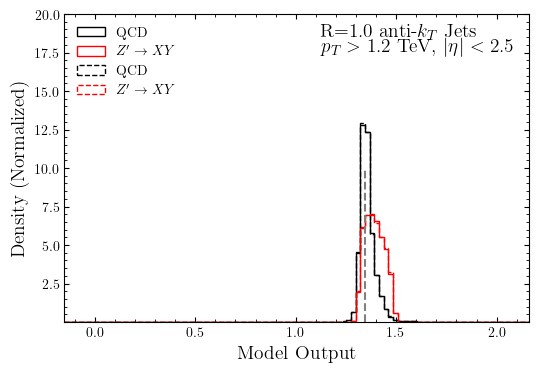

In [5]:
preds = model.predict(X, batch_size=1000)

nn_output_hist(preds, labels, y, fs)

### Run a $f_S$ sensitivity sweep

To determine the sensitivity of the method for different $f_S$, we apply the FORCE method to a logarithmic sweep of signal fractions. For stability, we average mutliple runs for an individual model, then repeat this process to get statistics. 

Note: this is quite computationally expensive and will take a while to run. Furthermore, results may differ depending on the network architecture and training dynamics that are chosen. Making the method more stable is part of future work.

In [65]:
fs = [0, 0.5, 0.0005, 0.005, 0.05]

signal_weights = [f / (1-f) for f in fs]

results = pd.DataFrame()
models = {}
efp_filt = [2, 3, 4, 5, 6, 7, 8]
labels_flatten = pd.DataFrame(np.concatenate([labels, labels]))


X = VarianceThreshold().fit_transform(np.concatenate((efps_normed[:,0,:], efps_normed[:,1,:]))[:,efp_filt])
y  = np.concatenate((jetpts[:,0]/1000, jetpts[:,1]/1000))
layers = [100, 100, 100]


for signal_weight in tqdm(signal_weights):
    result, models_full = signal_sweep(X, y, labels, signal_weight, layers)
    results = pd.concat([results, result])
    models[signal_weight] = models_full